# Machine Learning Assignment


# Logitboost 

# 1 a

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

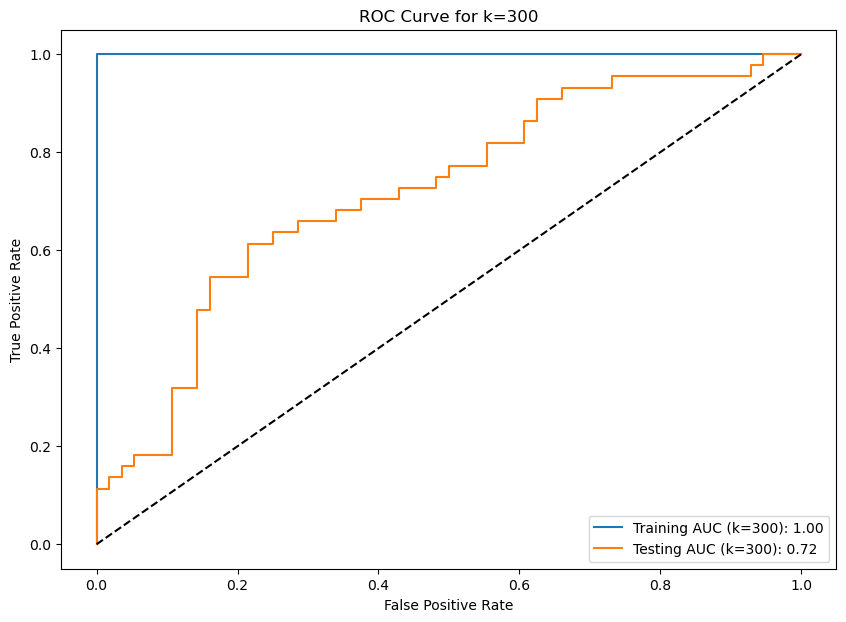

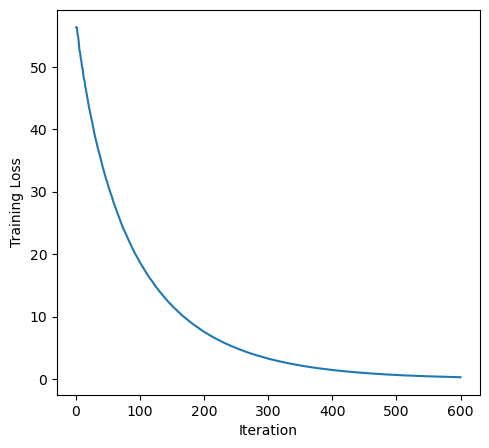

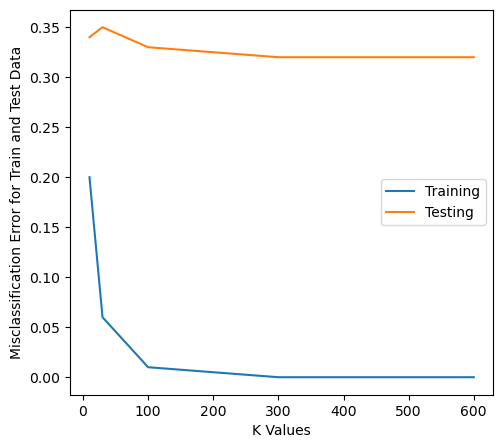

Misclassification Error for Train and Test Data:
     k  Training Errors  TestErrors
0   10             0.20        0.34
1   30             0.06        0.35
2  100             0.01        0.33
3  300             0.00        0.32
4  600             0.00        0.32


In [6]:
def logistic_regression_scaled(X_train, y_train, X_test, y_test, k_values, learning_rate=0.1, regularization_strength=0.01):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ones_train = np.ones(X_train_scaled.shape[0])
    ones_test = np.ones(X_test_scaled.shape[0])
    train_data = np.insert(X_train_scaled, 0, ones_train, axis=1)
    test_data = np.insert(X_test_scaled, 0, ones_test, axis=1)
    N_train = train_data.shape[0]
    M_train = train_data.shape[1]

    loss_list = []
    error_train_list = []
    error_test_list = []
    results_list = []

    for k in k_values:
        X_train_copy = train_data.copy()
        X_test_copy = test_data.copy()
        beta = np.zeros(M_train)

        for _ in range(0, k):
            l_pred = np.dot(X_train_copy, beta)
            prob = 1.0 / (1.0 + np.exp(-2 * l_pred))
            weights = prob * (1.0 - prob)
            resid = 0.5 * (y_train + 1) - prob
            resid[weights == 0] = 0
            resid[weights != 0] = resid[weights != 0] 
            / weights[weights != 0]
            coeff = np.zeros((2, M_train - 1))
            new_loss = np.zeros(M_train - 1)

            for j in range(0, M_train - 1):
                X_j = X_train_copy[:, j + 1]
                sum_w = np.sum(weights)
                sum_w_X_j = np.sum(weights * X_j)
                sum_w_X_j_squared = np.sum(weights * X_j ** 2)
                sum_w_residual = np.sum(weights * resid)
                sum_w_X_j_residual = np.sum(weights * X_j * resid)

                if (sum_w * sum_w_X_j_squared - sum_w_X_j ** 2) == 0:
                    beta_j = np.array([sum_w_residual / sum_w, 0])
                else:
                    beta_j = np.array([sum_w_X_j_squared * 
                                       sum_w_residual - sum_w_X_j * 
                                       sum_w_X_j_residual, sum_w *
                                       sum_w_X_j_residual - sum_w_X_j 
                                       * sum_w_residual]) / 
                    (sum_w * sum_w_X_j_squared - sum_w_X_j ** 2)

                l_pred_j = l_pred + 0.5 * (beta_j[0] + beta_j[1] * X_j)
                loss_j = np.sum(np.log(1 + np.exp(-2 * y_train * l_pred_j)))
                coeff[:, j] = beta_j
                new_loss[j] = loss_j

            min_loss_index = np.argmin(new_loss)
            beta[0] = beta[0] + learning_rate *
            (0.5 * coeff[0, min_loss_index] - regularization_strength * beta[0])
            beta[min_loss_index + 1] = beta[min_loss_index + 1] 
            + learning_rate * (0.5 * coeff[1][min_loss_index] - regularization_strength 
                               * beta[min_loss_index + 1])

            if k == k_values[-1]:
                loss_list.append(new_loss[min_loss_index])

        l_pred_train = np.dot(X_train_copy, beta)
        pred_train = np.where(l_pred_train > 0.0, 1, -1)
        error_train = 1 - np.mean(pred_train == y_train)
        error_train_list.append(error_train)

        l_pred_test = np.dot(X_test_copy, beta)
        pred_test = np.where(l_pred_test > 0.0, 1, -1)
        error_test = 1 - np.mean(pred_test == y_test)
        error_test_list.append(error_test)
        results_list.append({"k": k, "Training Errors": error_train, 
                             "TestErrors": error_test})

        if k == 300:
            p_train_300 = l_pred_train
            pred_train_300 = pred_train

            p_test_300 = l_pred_test
            pred_train_300 = pred_test

            # Calculate ROC curve and ROC area for training
            train_fpr_300, train_tpr_300, _ = roc_curve(y_train, p_train_300)
            train_auc_300 = roc_auc_score(y_train, p_train_300)

            # Calculate ROC curve and ROC area for testing
            test_fpr_300, test_tpr_300, _ = roc_curve(y_test, p_test_300)
            test_auc_300 = roc_auc_score(y_test, p_test_300)

            # Plot ROC curves
            plt.figure(figsize=(10, 7))
            plt.plot(train_fpr_300, train_tpr_300, 
                     label=f'Training AUC (k=300): {train_auc_300:.2f}')
            plt.plot(test_fpr_300, test_tpr_300, 
                     label=f'Testing AUC (k=300): {test_auc_300:.2f}')
            plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve for k=300')
            plt.legend(loc="lower right")
            plt.show()

    results_df = pd.concat([pd.DataFrame(result, index=[0]) 
                            for result in results_list], ignore_index=True)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 601), loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, error_train_list, label='Training')
    plt.plot(k_values, error_test_list, label='Testing')
    plt.xlabel('K Values')
    plt.ylabel('Misclassification Error for Train and Test Data')
    plt.legend()
    plt.show()

    return results_df


# Load data
X_train_data = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_6/arcene/arcene_train.data")
y_train_labels = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_6/arcene/arcene_train.labels")
X_test_data = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_6/arcene/arcene_valid.data")
y_test_labels = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_6/arcene/arcene_valid.labels")

# Define values of k
k_values = [10, 30, 100, 300, 600]

# Call the logistic regression function with feature scaling
results_df_scaled = logistic_regression_scaled(X_train_data, y_train_labels,
                                               X_test_data, y_test_labels, k_values)

print("Misclassification Error for Train and Test Data:")
print(results_df_scaled)


# 1 b

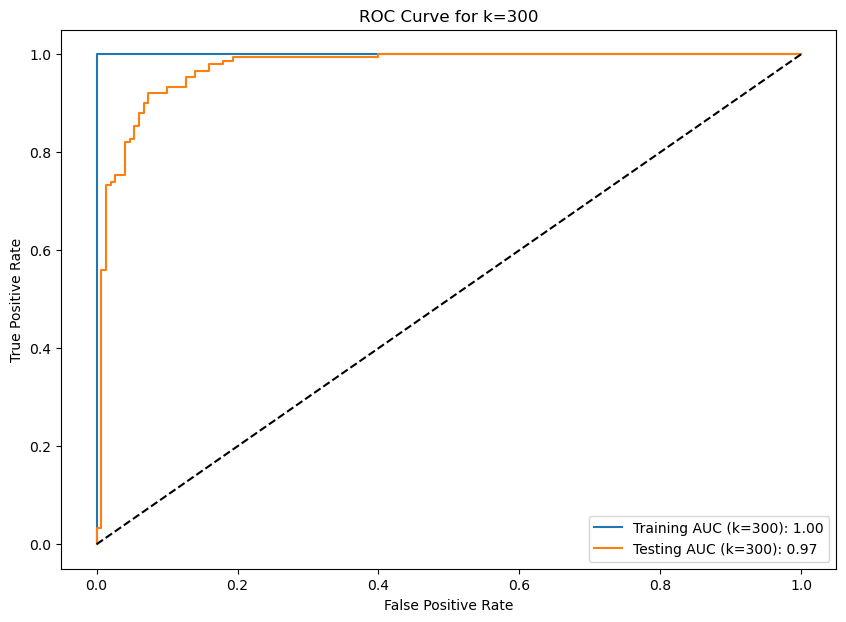

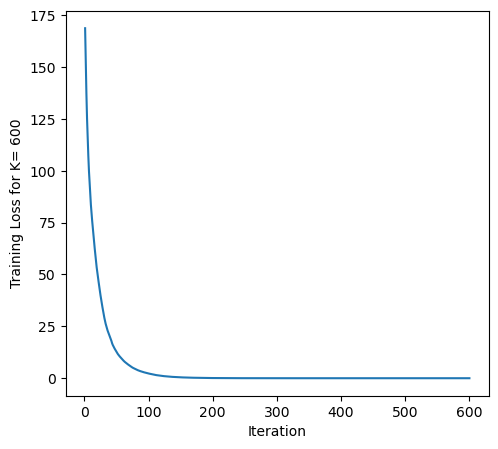

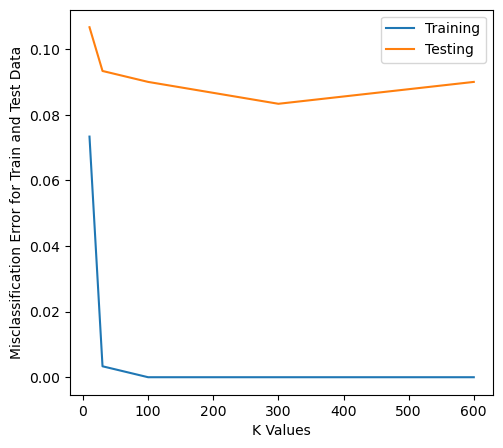

Misclassification Error for Train and Test Data:
     k  Training Errors  TestErrors
0   10         0.073333    0.106667
1   30         0.003333    0.093333
2  100         0.000000    0.090000
3  300         0.000000    0.083333
4  600         0.000000    0.090000


In [5]:
def logistic_regression_logit(X_train, y_train, X_test, y_test, k_values):
    ones_train = np.ones(X_train.shape[0])
    ones_test = np.ones(X_test.shape[0])
    train_data = np.insert(X_train, 0, ones_train, axis=1)
    test_data = np.insert(X_test, 0, ones_test, axis=1)
    N_train = train_data.shape[0]
    M_train = train_data.shape[1]

    loss_list = []
    error_train_list = []
    error_test_list = []
    results_list = []
    p_train_300 = None
    pred_train_300 = None

    for k in k_values:
        X_train_copy = train_data.copy()
        X_test_copy = test_data.copy()
        beta = np.zeros(M_train)

        for _ in range(0, k):
            l_pred = np.dot(X_train_copy, beta)
            probability = 1.0 / (1.0 + np.exp(-2 * l_pred))
            weights = probability * (1.0 - probability)
            residual = 0.5 * (y_train + 1) - probability
            residual[weights == 0] = 0
            residual[weights != 0] = residual[weights != 0] 
            / weights[weights != 0]
            coeff = np.zeros((2, M_train - 1))
            new_loss = np.zeros(M_train - 1)

            for j in range(0, M_train - 1):
                X_j = X_train_copy[:, j + 1]
                sum_w = np.sum(weights)
                sum_w_X_j = np.sum(weights * X_j)
                sum_w_X_j_squared = np.sum(weights * X_j ** 2)
                sum_w_residual = np.sum(weights * residual)
                sum_w_X_j_residual = np.sum(weights * X_j * residual)

                if (sum_w * sum_w_X_j_squared - sum_w_X_j ** 2) == 0:
                    beta_j = np.array([sum_w_residual / sum_w, 0])
                else:
                    beta_j = np.array([sum_w_X_j_squared * 
                                       sum_w_residual - sum_w_X_j * sum_w_X_j_residual, sum_w * 
                                       sum_w_X_j_residual - sum_w_X_j * sum_w_residual]) /
                    (sum_w * sum_w_X_j_squared - sum_w_X_j ** 2)

                l_pred_j = l_pred + 0.5 * (beta_j[0] + beta_j[1] * X_j)
                loss_j = np.sum(np.log(1 + np.exp(-2 * y_train * l_pred_j)))
                coeff[:, j] = beta_j
                new_loss[j] = loss_j

            min_loss_index = np.argmin(new_loss)
            beta[0] = beta[0] + 0.5 * coeff[0, min_loss_index]
            beta[min_loss_index + 1] = beta[min_loss_index + 1] 
            + 0.5 * coeff[1][min_loss_index]

            if k == k_values[-1]:
                loss_list.append(new_loss[min_loss_index])

        l_pred_train = np.dot(X_train_copy, beta)
        pred_train = np.where(l_pred_train > 0.0, 1, -1)
        error_train = 1 - np.mean(pred_train == y_train)
        error_train_list.append(error_train)

        l_pred_test = np.dot(X_test_copy, beta)
        pred_test = np.where(l_pred_test > 0.0, 1, -1)
        error_test = 1 - np.mean(pred_test == y_test)
        error_test_list.append(error_test)
        results_list.append({"k": k, "Training Errors": error_train, 
                             "TestErrors": error_test})

        if k == 300:
            p_train_300 = l_pred_train
            pred_train_300 = pred_train
            
            p_test_300 = l_pred_test
            pred_train_300 = pred_test
            
            # Calculate ROC curve and ROC area for training
            train_fpr_300, train_tpr_300, _ = roc_curve(y_train, p_train_300)
            train_auc_300 = roc_auc_score(y_train, p_train_300)

            # Calculate ROC curve and ROC area for testing
            test_fpr_300, test_tpr_300, _ = roc_curve(y_test, p_test_300)
            test_auc_300 = roc_auc_score(y_test, p_test_300)

            # Plot ROC curves
            plt.figure(figsize=(10, 7))
            plt.plot(train_fpr_300, train_tpr_300, 
                     label=f'Training AUC (k=300): {train_auc_300:.2f}')
            plt.plot(test_fpr_300, test_tpr_300, 
                     label=f'Testing AUC (k=300): {test_auc_300:.2f}')
            plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve for k=300')
            plt.legend(loc="lower right")
            plt.show()

    results_df = pd.concat([pd.DataFrame(result, index=[0]) 
                            for result in results_list], ignore_index=True)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 601), loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss for K= 600')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, error_train_list, label='Training')
    plt.plot(k_values, error_test_list, label='Testing')
    plt.xlabel('K Values')
    plt.ylabel('Misclassification Error for Train and Test Data')
    plt.legend()
    plt.show()


    return results_df

# Load data

X_train_data = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_train.csv", delimiter=',') 
y_train_labels = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_train.labels")

X_test_data = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_valid.csv", delimiter=',') 
y_test_labels = np.genfromtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_3/dexter/dexter_valid.labels")


# Define values of k
k_values = [10, 30, 100, 300, 600]

# Call the logistic regression function
results_df = logistic_regression_logit(X_train_data, y_train_labels, 
                                       X_test_data, y_test_labels, k_values)

print("Misclassification Error for Train and Test Data:")
print(results_df)


# 1 C

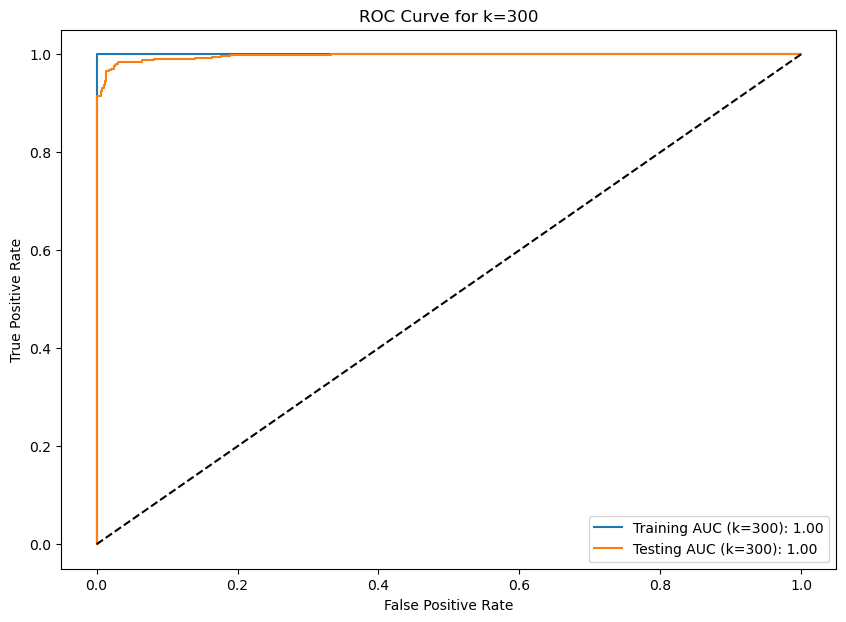

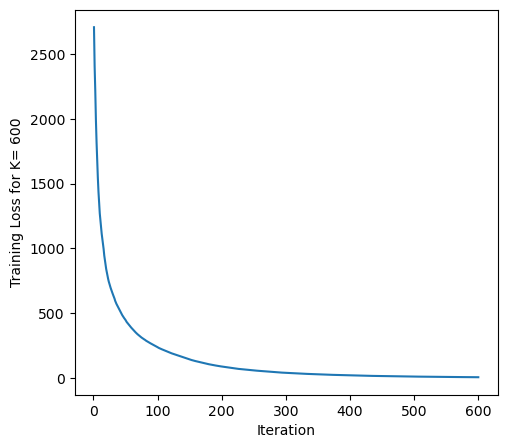

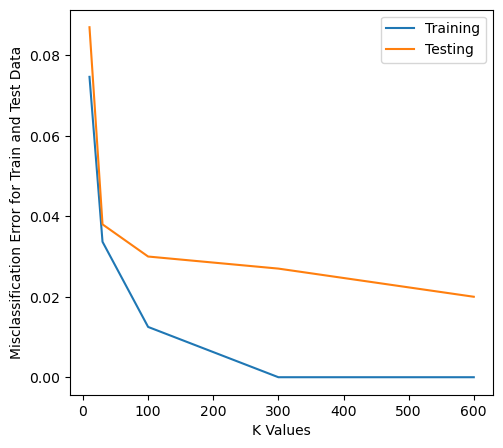

Misclassification Error for Train and Test Data:
     k  Training Errors  TestErrors
0   10         0.074667       0.087
1   30         0.033667       0.038
2  100         0.012500       0.030
3  300         0.000000       0.027
4  600         0.000000       0.020


In [3]:
def logistic_regression_logit(X_train, y_train, X_test, y_test, k_values):
    ones_train = np.ones(X_train.shape[0])
    ones_test = np.ones(X_test.shape[0])
    train_data = np.insert(X_train, 0, ones_train, axis=1)
    test_data = np.insert(X_test, 0, ones_test, axis=1)
    N_train = train_data.shape[0]
    M_train = train_data.shape[1]

    loss_list = []
    error_train_list = []
    error_test_list = []
    results_list = []
    p_train_300 = None
    pred_train_300 = None

    for k in k_values:
        X_train_copy = train_data.copy()
        X_test_copy = test_data.copy()
        beta = np.zeros(M_train)

        for _ in range(0, k):
            l_pred = np.dot(X_train_copy, beta)
            probability = 1.0 / (1.0 + np.exp(-2 * l_pred))
            weights = probability * (1.0 - probability)
            residual = 0.5 * (y_train + 1) - probability
            residual[weights == 0] = 0
            residual[weights != 0] = residual[weights != 0] 
            / weights[weights != 0]
            coeff = np.zeros((2, M_train - 1))
            new_loss = np.zeros(M_train - 1)

            for j in range(0, M_train - 1):
                X_j = X_train_copy[:, j + 1]
                sum_w = np.sum(weights)
                sum_w_X_j = np.sum(weights * X_j)
                sum_w_X_j_squared = np.sum(weights * X_j ** 2)
                sum_w_residual = np.sum(weights * residual)
                sum_w_X_j_residual = np.sum(weights * X_j * residual)

                if (sum_w * sum_w_X_j_squared - sum_w_X_j ** 2) == 0:
                    beta_j = np.array([sum_w_residual / sum_w, 0])
                else:
                    beta_j = np.array([sum_w_X_j_squared * 
                                       sum_w_residual - sum_w_X_j * sum_w_X_j_residual, 
                                       sum_w * sum_w_X_j_residual - sum_w_X_j * sum_w_residual]) /
                    (sum_w * sum_w_X_j_squared - sum_w_X_j ** 2)

                l_pred_j = l_pred + 0.5 * (beta_j[0] + beta_j[1] * X_j)
                loss_j = np.sum(np.log(1 + np.exp(-2 * y_train * l_pred_j)))
                coeff[:, j] = beta_j
                new_loss[j] = loss_j

            min_loss_index = np.argmin(new_loss)
            beta[0] = beta[0] + 0.5 * coeff[0, min_loss_index]
            beta[min_loss_index + 1] = beta[min_loss_index + 1] +
            0.5 * coeff[1][min_loss_index]

            if k == k_values[-1]:
                loss_list.append(new_loss[min_loss_index])

        l_pred_train = np.dot(X_train_copy, beta)
        pred_train = np.where(l_pred_train > 0.0, 1, -1)
        error_train = 1 - np.mean(pred_train == y_train)
        error_train_list.append(error_train)

        l_pred_test = np.dot(X_test_copy, beta)
        pred_test = np.where(l_pred_test > 0.0, 1, -1)
        error_test = 1 - np.mean(pred_test == y_test)
        error_test_list.append(error_test)
        results_list.append({"k": k, "Training Errors": error_train, 
                             "TestErrors": error_test})

        if k == 300:
            p_train_300 = l_pred_train
            pred_train_300 = pred_train
            
            p_test_300 = l_pred_test
            pred_train_300 = pred_test
            
            # Calculate ROC curve and ROC area for training
            train_fpr_300, train_tpr_300, _ = roc_curve(y_train, p_train_300)
            train_auc_300 = roc_auc_score(y_train, p_train_300)

            # Calculate ROC curve and ROC area for testing
            test_fpr_300, test_tpr_300, _ = roc_curve(y_test, p_test_300)
            test_auc_300 = roc_auc_score(y_test, p_test_300)

            # Plot ROC curves
            plt.figure(figsize=(10, 7))
            plt.plot(train_fpr_300, train_tpr_300, 
                     label=f'Training AUC (k=300): {train_auc_300:.2f}')
            plt.plot(test_fpr_300, test_tpr_300, 
                     label=f'Testing AUC (k=300): {test_auc_300:.2f}')
            plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve for k=300')
            plt.legend(loc="lower right")
            plt.show()

    results_df = pd.concat([pd.DataFrame(result, index=[0]) 
                            for result in results_list], ignore_index=True)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 601), loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss for K= 600')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, error_train_list, label='Training')
    plt.plot(k_values, error_test_list, label='Testing')
    plt.xlabel('K Values')
    plt.ylabel('Misclassification Error for Train and Test Data')
    plt.legend()
    plt.show()


    return results_df

# Load data

X_train_data = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_train.data") 
y_train_labels = np.loadtxt("//Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_train.labels")

X_test_data = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_valid.data") 
y_test_labels = np.loadtxt("/Users/gaganullas19/Documents/Spring2024/AppliedMachineLearning/Homework_4/Gisette/gisette_valid.labels")


# Define values of k
k_values = [10, 30, 100, 300, 600]

# Call the logistic regression function
results_df = logistic_regression_logit(X_train_data, y_train_labels, 
                                       X_test_data, y_test_labels, k_values)

print("Misclassification Error for Train and Test Data:")
print(results_df)
